# BASELINE MODEL

In [1]:
import preprocessing as pp
import conf as c
import baseline_model as bm
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import tensorflow_datasets as tfds
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### We create a tensorflow dataset with the data from the different folders

In [2]:
anchor = tf.data.Dataset.list_files(os.path.join(c.ANC_PATH, '*.jpg')).take(100)
positive = tf.data.Dataset.list_files(os.path.join(c.POS_PATH, '*.jpg')).take(100)
negative = tf.data.Dataset.list_files(os.path.join(c.NEG_PATH, '*.jpg')).take(100);

2022-01-17 20:43:46.080695: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = pp.create_dataset(anchor, positive, negative)
train, test = pp.split_train_test(data, 0.8, batch_size=1)

In [ ]:
We transf

In [4]:
train = tfds.as_numpy(train)
test = tfds.as_numpy(test)

In [5]:
X_train, y_train = bm.tf_to_pd_dataframe(train)
X_test, y_test = bm.tf_to_pd_dataframe(test)

### Let's check if the data is balanced

**TRAIN SET**

In [6]:
pd.DataFrame(y_train).value_counts() / y_train.shape[0]

0.0    0.5125
1.0    0.4875
dtype: float64

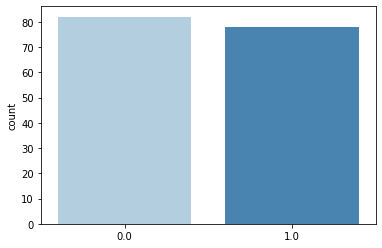

In [7]:
sns.countplot(y_train,palette='Blues');

**TEST SET**

In [8]:
pd.DataFrame(y_test).value_counts() / y_test.shape[0]

0.0    0.525
1.0    0.475
dtype: float64

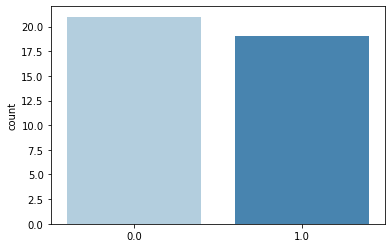

In [9]:
sns.countplot(y_test,palette='Blues');

The data is balanced, if we do a baseline model where all the samples are predicted as 1,the accuracy would be 55%. 

## BASELINE MODEL

In [10]:
clf = BernoulliNB(binarize=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [11]:
accuracy_score(y_test,y_pred)

0.75

The accuracy is better than the random guess